In [106]:
import datasets
from datasets import load_dataset
import pandas as pd
import nltk
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import re
import numpy as np
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rowjak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rowjak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [107]:
path = os.getcwd()

In [108]:
df_train = pd.read_parquet(os.path.join(path, "dataset/train_combined.parquet"))

In [109]:
df_train_sample = pd.read_parquet(os.path.join(path, "dataset/train_sample_combined.parquet"))
df_xtreme_dev = pd.read_parquet(os.path.join(path, "dataset/xtreme_dev_combined.parquet"))
df_xtreme_test = pd.read_parquet(os.path.join(path, "dataset/xtreme_test_combined.parquet"))

In [121]:
df_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38777 entries, 42855 to 90081
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  38777 non-null  int64 
 1   url                 38777 non-null  object
 2   clean_article       38777 non-null  object
 3   clean_summary       38777 non-null  object
 4   extractive_summary  38777 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [124]:
df_test = pd.read_parquet(os.path.join(path, "dataset/test_combined.parquet"))

In [146]:
def extract_article(sentences):
    # Gabungkan array kata-kata menjadi kalimat
    text = ' '.join([' '.join(sentence) for sentence in sentences])
    # Hilangkan spasi sebelum tanda baca seperti .,;:!?()
    text = re.sub(r'\s+([.,:;!?()])', r'\1', text)
    # Hilangkan spasi setelah tanda baca '.' jika huruf setelahnya kecil
    text = re.sub(r'\.\s+([a-z])', r'.\1', text)
    
    text = re.sub(r'\(\s+', '(', text)  # Hilangkan spasi setelah '('
    text = re.sub(r'\s+\)', ')', text)  # Hilangkan spasi sebelum ')'
    
    text = re.sub(r'\[\s+', '[', text)  # Hilangkan spasi setelah '['
    text = re.sub(r'\s+\]', ']', text)  # Hilangkan spasi sebelum ']'
    
    return text

In [181]:
df_used = df_train

In [182]:
df_used['ext_clean_article'] = df_used['clean_article'].apply(extract_article)
df_used['ext_clean_summary'] = df_used['clean_summary'].apply(extract_article)

In [183]:
def extract_sentences_from_index(clean_article, extractive_summary):
    return [clean_article[i] for i in extractive_summary]

In [184]:
df_used['extractive_summary_sentences'] = df_used.apply(lambda row: extract_sentences_from_index(row['clean_article'], row['extractive_summary']), axis=1)

In [185]:
df_used['ext_extractive_summary'] = df_used['extractive_summary_sentences'].apply(extract_article)

In [186]:
def preprocessing_article(text):
    # ubah semua menjadi huruf kecil
    text = text.lower()
    # hilangkan teks yang memiliki tanda kurun () dan []
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    # hilangkan awalan liputan6.com kemudian setelah itu tanda :
    text = re.sub(r'^liputan6\.com, [^:]+: ', '', text)
    # hilangkan semua tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    # hilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [187]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [188]:
df_used['prep_clean_article'] = df_used['ext_clean_article'].apply(preprocessing_article)
df_used['prep_clean_summary'] = df_used['ext_clean_summary'].apply(preprocessing_article)
df_used['prep_extractive_summary'] = df_used['ext_extractive_summary'].apply(preprocessing_article)
df_used['prep_clean_article_no_sw'] = df_used['prep_clean_article'].apply(remove_stopwords)

In [189]:
random_sample = df_used.sample(n=10, random_state=1)  # random_state untuk konsistensi hasil
for index, row in random_sample.iterrows():
    print(f"1. Index: {index}")
    print(f"2. Url:\n {row['url']}")
    
    print(f"3.1. Clean Article:\n {row['ext_clean_article']}")
    print(f"3.2. Prep Clean Article:\n {row['prep_clean_article']}")
    print(f"3.3. Prep Clean Article No Stopwords:\n {row['prep_clean_article_no_sw']}")
    
    print(f"4.1. Clean Summary:\n {row['ext_clean_summary']}")
    print(f"4.2. Prep Clean Summary:\n {row['prep_clean_summary']}")
    
    print(f"5.1. Extractive Summary:\n {row['ext_extractive_summary']}")
    print(f"5.2. Prep Extractive Summary:\n {row['prep_extractive_summary']}")
    print("-" * 100)  # Pembatas antar tweet

1. Index: 130774
2. Url:
 https://www.liputan6.com/news/read/276057/ledakan-tabung-gas-lima-warga-luka-luka
3.1. Clean Article:
 Liputan6.com, Bekasi: Lima orang mengalami luka bakar serius di sekujur tubuh akibat edakan tabung gas di Kampung Kebalen, Kabupaten Bekasi, Jawa Barat, Sabtu(8/5). Kepala Kepolisian Sektor(Kapolsek) Babelan, AKP H. Rosid, mengatakan, lokasi ledakan diduga dijadikan sebagai tempat usaha gas ilegal milik warga bernama Marzuki. Lokasi tersebut dijadikan tempat usaha pengisian gas korek api. " Ratusan tabung gas masing-masing berukuran 50 kilogram dan 10 miligram meledak sekitar pukul 09: 00 WIB. Untuk tabung gas besar yang meledak berjumlah puluhan, sementara gas ukuran kecil yang meledak mencapai ratusan. Hingga kini masih kami lakukan upaya pendataan jumlah pastinya, " ujar kapolsek. Akibat peristiwa itu sebanyak lima karyawan masing-masing bernama Jhokan(41), Apit(41), Acep(50), Udin(25), dan Ero(24) mengalami luka bakar 90 persen di sekujur tubuh dan dilari

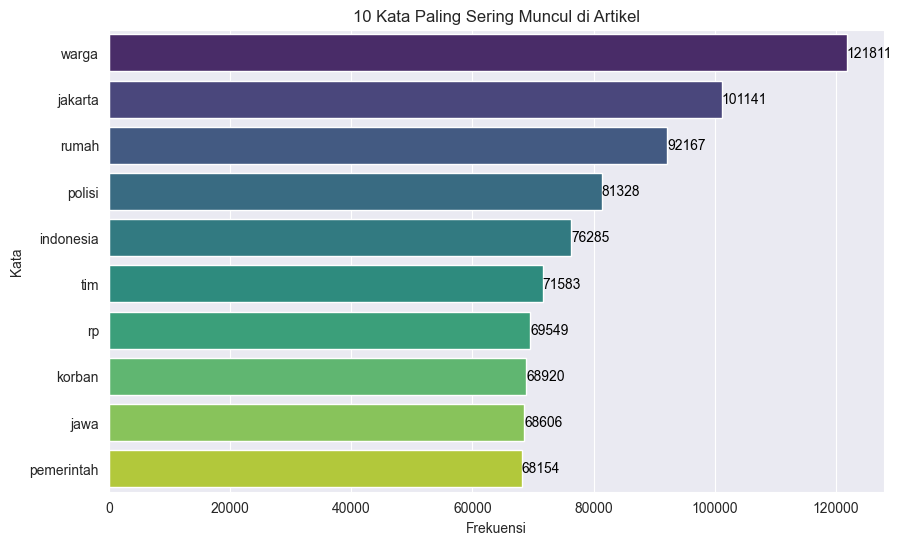

In [190]:
from collections import Counter

text = list(df_used['prep_clean_article_no_sw'])

jumlah_rank = 10

words = []
for line in text:
    words_in_line = line.split()
    words.extend(words_in_line)

words_count = Counter(words)
most_common_words = words_count.most_common(jumlah_rank)
most_common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
total_words = sum(words_count.values())
most_common_df['percentage'] = (most_common_df['count'] / total_words) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=most_common_df, palette='viridis', hue='word', dodge=False)

for i in range(len(most_common_df)):
    count = most_common_df['count'][i]
    plt.text(count, i, f'{count}', color='black', va='center')

plt.title(f'{jumlah_rank} Kata Paling Sering Muncul di Artikel')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()